In [1]:
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from skimage.transform import resize
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import csv
import cv2
import numpy as np

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout

from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt





In [2]:
dirname = os.path.join(os.getcwd(), '/home/ruben/Escritorio/imagenes Circuito Original/todas/')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

angles=[]
firstline = True

print("leyendo imagenes de ",imgpath)


with open('/home/ruben/Escritorio/vo_epipolar_regresion/build/todas.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if firstline:    #skip first line
            firstline = False
            continue
        angle = float(row[1])
        angles.append([angle])
        source_path1 = row[0]
        for root, dirnames, filenames in os.walk(imgpath):
            for filename in filenames:
                if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                    if(filename==source_path1):
                        cant=cant+1
                        filepath = os.path.join(root, filename)
                        image = plt.imread(filepath)
                        height,width=64, 80
                        image_resized = cv2.resize(image, (width,height))
                        images.append(image_resized)
                        b = "Leyendo..." + str(cant)
                        print (b, end="\r")
                        if prevRoot !=root:
                            print(root, cant)
                            prevRoot=root
                            directories.append(root)
                            dircount.append(cant)
                            cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /home/ruben/Escritorio/imagenes Circuito Original/todas//
/home/ruben/Escritorio/imagenes Circuito Original/todas// 1
Directorios leidos: 1
Imagenes en cada directorio [1915]
suma Total de imagenes en subdirs: 1915


(1915, 64, 80, 3)
(1915, 1)


[Text(0.5, 1.0, 'Ángulos de las imagenes'),
 Text(0, 0.5, 'Repeticiones'),
 Text(0.5, 0, 'ángulo')]

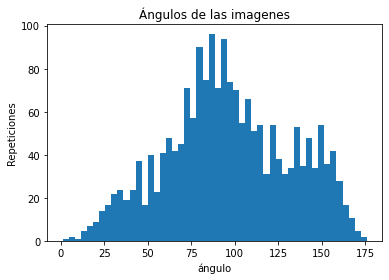

In [3]:
Y = np.array(angles)
X = np.array(images, dtype=np.uint8) 
print(X.shape)
print(Y.shape)

plt.hist(Y, bins=50)
plt.gca().set(title='Ángulos de las imagenes', ylabel='Repeticiones',xlabel='ángulo')

In [4]:
#para duplicar imagenes
images_aug,angles_aug=[],[]
for image_aux,angle_aux in zip(X,Y):
    images_aug.append(image_aux)
    angles_aug.append(angle_aux)
    images_aug.append(cv2.flip(image_aux,1))
    angles_aug.append(180 -angle_aux)
a = np.array(images_aug, dtype=np.uint8)
b = np.array(angles_aug) 
print(a.shape)
print(b.shape)
X=a
Y=b

(3830, 64, 80, 3)
(3830, 1)


[Text(0.5, 1.0, 'Ángulos de las imagenes tras aumento'),
 Text(0, 0.5, 'Repeticiones'),
 Text(0.5, 0, 'ángulo')]

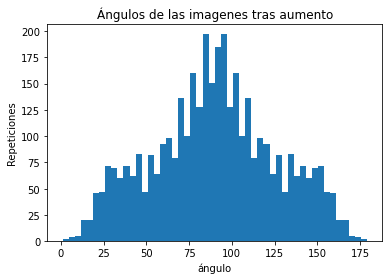

In [5]:
plt.hist(Y, bins=50)
plt.gca().set(title='Ángulos de las imagenes tras aumento', ylabel='Repeticiones',xlabel='ángulo')

In [6]:
from PIL import Image

train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.2)
print(train_X.shape)
print(train_Y.shape)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

train_Y = train_Y.astype('float32')
test_Y= test_Y.astype('float32')
train_Y= train_Y/ 180
test_Y= test_Y/ 180

print(train_X.shape,test_X.shape,train_Y.shape,test_Y.shape)
print(train_Y.shape)


(3064, 64, 80, 3)
(3064, 1)
Training data shape :  (3064, 64, 80, 3) (3064, 1)
Testing data shape :  (766, 64, 80, 3) (766, 1)
(3064, 64, 80, 3) (766, 64, 80, 3) (3064, 1) (766, 1)
(3064, 1)


In [7]:
model = Sequential()
model.add(Conv2D(filters=24, kernel_size=(5, 5), activation='elu', strides=(2, 2),input_shape=(height, width,3)))
model.add(Conv2D(filters=36, kernel_size=(5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(filters=48,kernel_size=(5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(filters=64,kernel_size=( 3, 3), activation='elu'))
model.add(Conv2D(filters=64,kernel_size=( 3, 3), activation='elu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 38, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 7, 48)          43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 5, 64)          27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 3, 64)          36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0

In [8]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')


model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))

move_train =model.fit(train_X,train_Y,validation_data=(test_X,test_Y ),shuffle=True,epochs=15,callbacks=[checkpoint])



test_eval = model.evaluate(test_X, test_Y, verbose=1)
print(test_eval)


/home/ruben/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15
96/96 [==============================] - 5s 46ms/step - loss: 0.0664 - val_loss: 0.0428
Epoch 2/15
96/96 [==============================] - 5s 50ms/step - loss: 0.0480 - val_loss: 0.0397
Epoch 3/15
96/96 [==============================] - 7s 71ms/step - loss: 0.0428 - val_loss: 0.0346
Epoch 4/15
96/96 [==============================] - 7s 72ms/step - loss: 0.0406 - val_loss: 0.0336
Epoch 5/15
96/96 [==============================] - 6s 64ms/step - loss: 0.0372 - val_loss: 0.0338
Epoch 6/15
96/96 [==============================] - 6s 60ms/step - loss: 0.0359 - val_loss: 0.0321
Epoch 7/15
96/96 [==============================] - 6s 60ms/step - loss: 0.0334 - val_loss: 0.0317
Epoch 8/15
96/96 [==============================] - 6s 61ms/step - loss: 0.0330 - val_loss: 0.0323
Epoch 9/15
96/96 [==============================] - 6s 59ms/step - loss: 0.0318 - val_loss: 0.0307
Epoch 10/15
96/96 [==============================] - 5s 55ms/step - loss: 0.0317 - val_loss: 0.0335
Epoch 11/

In [10]:
model.save("prueba.h5")

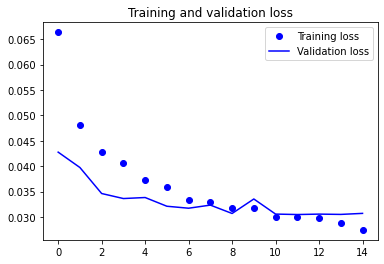

In [11]:
loss = move_train.history['loss']
val_loss = move_train.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 

In [12]:
new_model = keras.models.load_model('pt.h5')
predicted_classes2 = new_model.predict(test_X)


In [13]:
predicted_classes=[]
for predicted_move in predicted_classes2:
    predicted_classes.append(predicted_move.tolist().index(max(predicted_move)))
predicted_classes=np.array(predicted_classes)

In [ ]:
plt.figure(figsize=(20,20))
for i,j in enumerate(predicted_classes2):
    plt.subplot(10,10,i+1)
    plt.imshow(test_X[i].reshape(height, width,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(np.round(predicted_classes2[i],2),np.round(test_Y[i],2)))
    plt.tight_layout()
